# Counter ring concept

In this modulo counter the neurons are arranged in a ring, with recurrent connections to themselves that cause hysteretic behaviour, as well as excitatory connections "forward" in the ring, and inhibitory connections "backwards". In addition, they all get the same external input (which has some background activity that falls within the hysteresis range, meaning that when idle, the cells remain in their current state).

There are some useful properties:
* All cells are identical.

This setup, of course, has the following issues:
* It presumably violates Dale's law, since the same neurons are both inhibitory and excitatory.
* It seems quite contrived.
* It is currently only set up to integrate input pulses of fixed magnitude; not sure to what extent it can be made speed-sensitive.

In general, the RNS approach also has the following issues:
* Decoding is difficult (although it can allegedly be done using a neural network).
* It does not bear much resemblance to the synaptic weight memory.

In [2]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
from scipy.special import expit
import matplotlib.pyplot as plt

In [3]:
# Backward connection weight:
b = -0.2

# Forward connection weight:
f = 0.3

# Autapse weight:
h = 0.5

# Thresholds:
I_up = 0.8
I_down = I_up - h

# Time constant and activation function slope:
T = 0.2
K = 100

# Activation function:
def a(x):
    return expit((x - I_up)*K)

# Construct the weight matrix:
N = 7
W = np.array([np.roll(np.array([h, b, *([0]*(N-3)), f]), n) for n in range(N)])

print(W)

[[ 0.5 -0.2  0.   0.   0.   0.   0.3]
 [ 0.3  0.5 -0.2  0.   0.   0.   0. ]
 [ 0.   0.3  0.5 -0.2  0.   0.   0. ]
 [ 0.   0.   0.3  0.5 -0.2  0.   0. ]
 [ 0.   0.   0.   0.3  0.5 -0.2  0. ]
 [ 0.   0.   0.   0.   0.3  0.5 -0.2]
 [-0.2  0.   0.   0.   0.   0.3  0.5]]


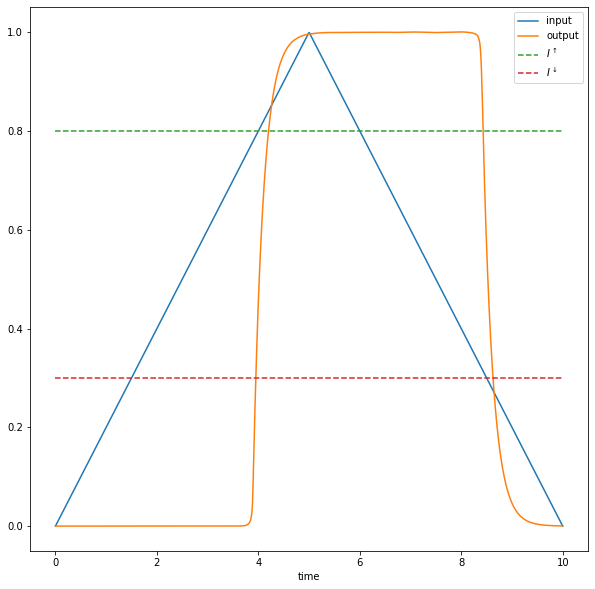

In [4]:
# Simulate a single neuron to examine hysteretic properties:
I = lambda t: np.ones

t = np.linspace(0, 10, 1000)

# A pyramid-shaped input:
def I(t):
    if t < 5:
        return t / 5
    else:
        return 2 - t / 5

def dvdt(t, v):
    return (1/T) * (a(h*v + I(t)) - v)

# Solve in time:
solution = solve_ivp(dvdt, (0, 10), np.array([0]), t_eval = t)

plt.figure(figsize=(10, 10))
plt.plot(t, [I(t) for t in t], label="input")
plt.plot(t, solution.y[0], label="output")
plt.plot([0, 10], [I_up, I_up], '--', label="$I^{\\uparrow}$")
plt.plot([0, 10], [I_down, I_down], '--', label="$I^{\\downarrow}$")
plt.legend()
plt.xlabel("time")
plt.show()

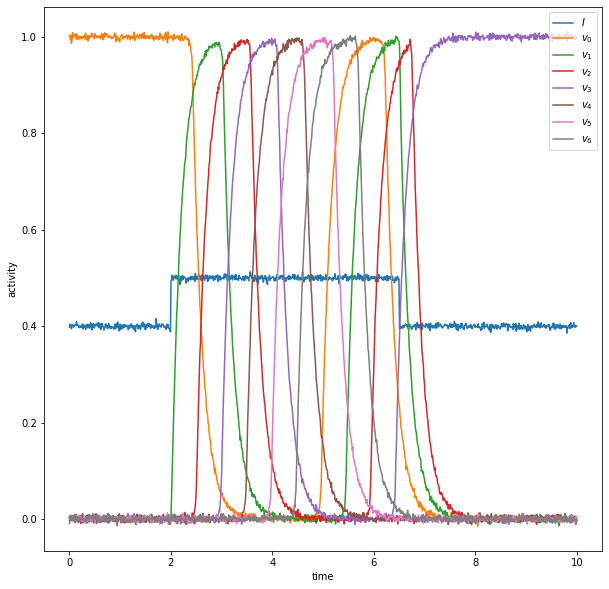

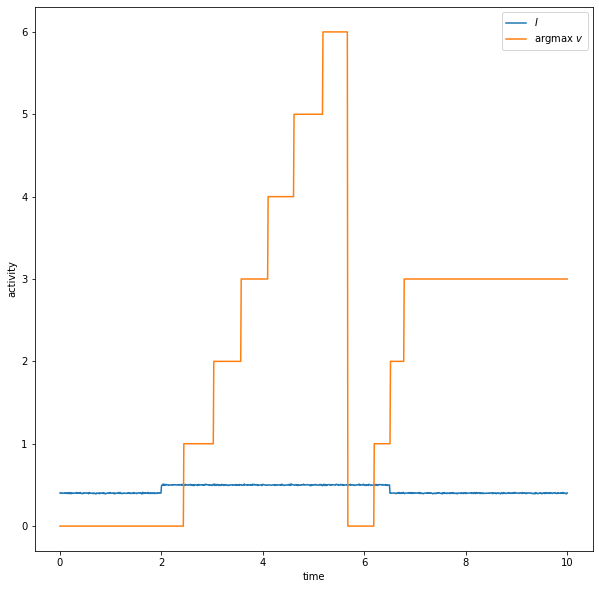

In [33]:
# There needs to be something to inhibit, so we need some background activity:
background = 0.4

# The bump size:
bump = 0.1

# Some noise (1% of background activity)
noise = 0.01 * background
I = lambda t: np.ones(np.shape(t)) * background + bump * ((t > 2) * (t < 6.5)) + np.random.normal(0, noise, np.shape(t))

# The final dynamics:
def dvdt(t, v):
    return (1/T) * (a(W @ v + I(t)) - v)

# IVP solving parameters:
t0 = 0
tf = 10
v0 = np.zeros(N)
v0[0] = 1

# Solve:
solution = solve_ivp(dvdt, (t0, tf), v0, t_eval=t)
v = solution.y + np.random.normal(0, noise, np.shape(solution.y))
y = np.argmax(v, 0)

# Plot:
plt.figure(figsize=(10, 10))
plt.plot(t, I(t), label="$I$")
for i in range(N):
    plt.plot(solution.t, v[i,:], label=f"$v_{i}$")
plt.legend()
plt.ylabel("activity")
plt.xlabel("time")
plt.show()

plt.figure(figsize=(10, 10))
plt.plot(t, I(t), label="$I$")
plt.plot(solution.t, y, label="argmax $v$")
plt.legend()
plt.xlabel("time")
plt.ylabel("activity")
plt.show()